Opening videos...
Video properties: 160x120, 800 frames, 30 FPS
Processing frames for analysis...
Processing frame 0/800
Processing frame 50/800
Processing frame 100/800
Processing frame 150/800
Processing frame 200/800
Processing frame 250/800
Processing frame 300/800
Processing frame 350/800
Processing frame 400/800
Processing frame 450/800
Processing frame 500/800
Processing frame 550/800
Processing frame 600/800
Processing frame 650/800
Processing frame 700/800
Processing frame 750/800

Metrics saved to frame_metrics.csv

=== SUMMARY STATISTICS ===
                    MSE                             PSNR                   \
                   mean         std         max     mean     std      min   
clip                                                                        
PCA_rank3     42.827702   37.588200  294.167786  33.5131  4.0989  23.4449   
SVD_rank3      0.000000    0.000000    0.000000      inf     NaN      inf   
batch_rank3  202.903503  112.979401  750.908997  25.5817

C:\Users\Nick\AppData\Local\Temp\ipykernel_21452\1808969417.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(ssim_data, labels=labels)


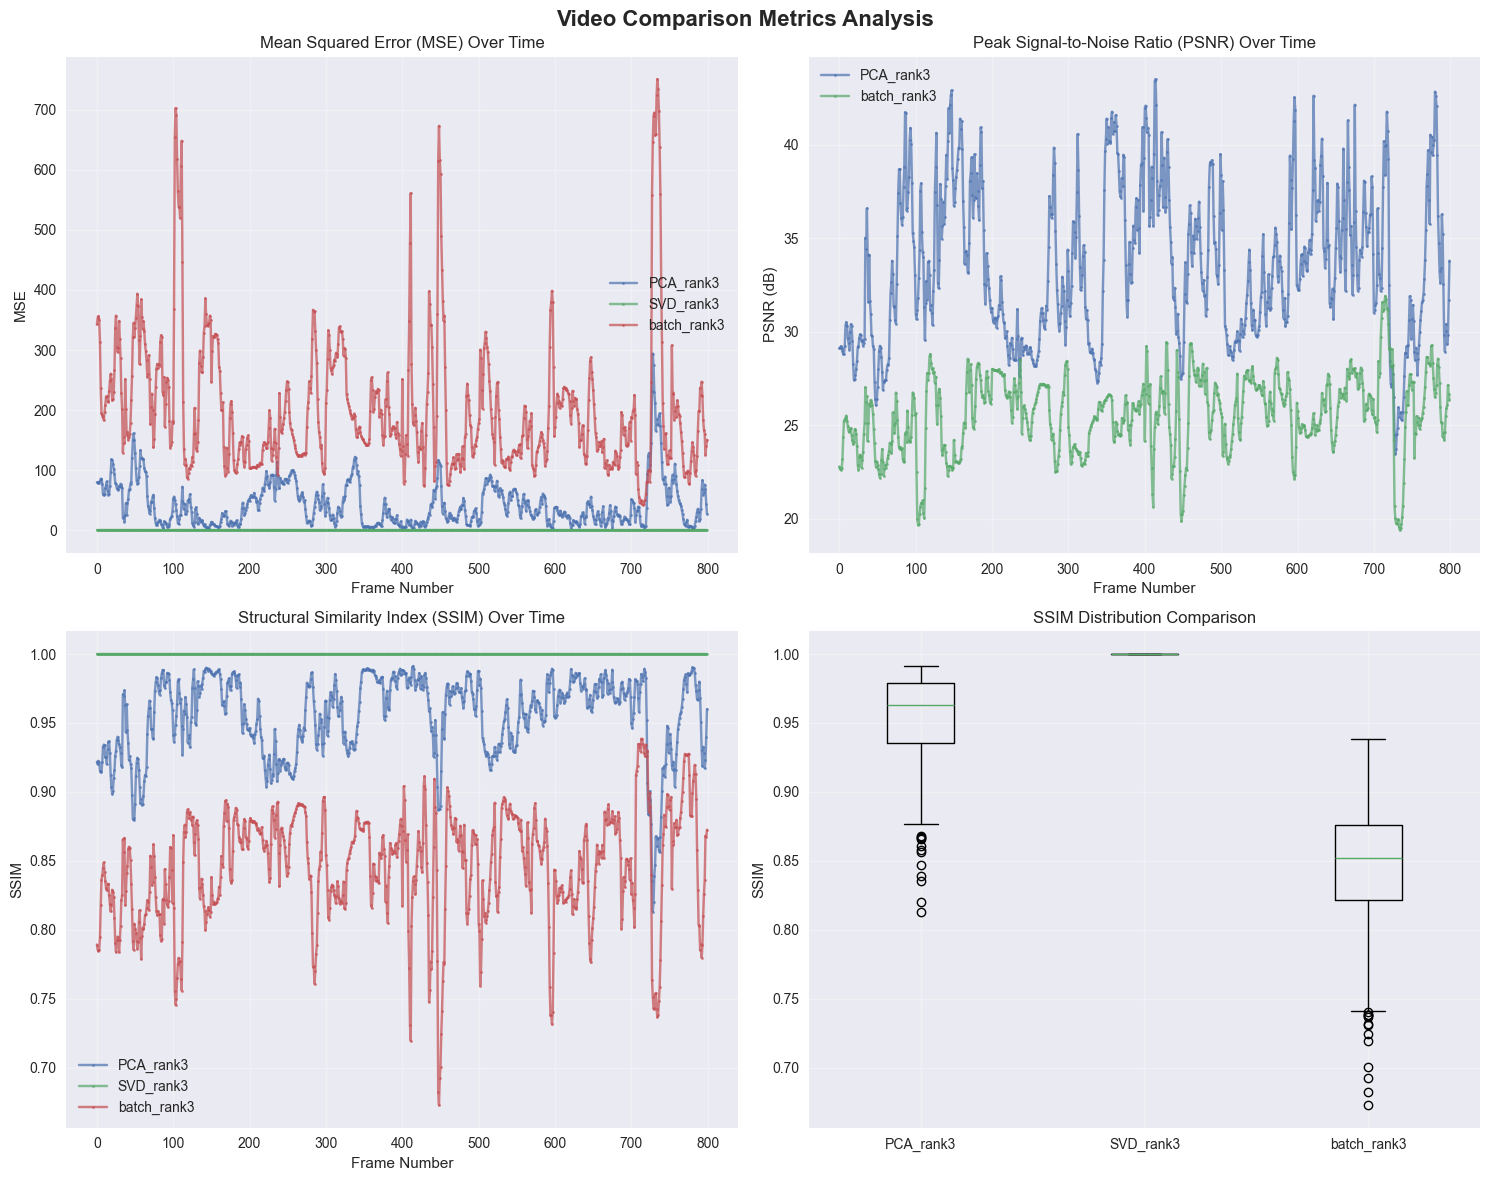


Starting real-time comparison...
Press 'q' to quit, 'p' to pause/resume, 'r' to restart

=== ANALYSIS COMPLETE ===
Generated files:
- Metrics: frame_metrics.csv
- Difference videos: differences_out/
- Comparison plots: metrics_comparison.png


In [1]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.metrics import structural_similarity as ssim

# ---------- user inputs ----------
clips = {
    "PCA_rank3": "boostrap_PCA_rank3.avi",
    "SVD_rank3": "boostrap_rank3.avi",
    "batch_rank3": "boostrap_rank3_batch.avi",
}
out_diff_dir = Path("differences_out")
metrics_csv = "frame_metrics.csv"
make_diff_vids = True
make_plots = True
realtime_comparison = True
slow_motion_factor = 2  # Show videos at 1/2 speed
difference_threshold = 30  # Threshold for highlighting significant differences


# ---------------------------------

def open_video(path):
    cap = cv2.VideoCapture(str(path))
    if not cap.isOpened():
        raise IOError(f"Cannot open {path}")
    return cap, int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


def create_heatmap_overlay(diff_image, threshold=30):
    """Create a colored heatmap overlay for differences"""
    # Normalize difference image
    diff_norm = cv2.normalize(diff_image, None, 0, 255, cv2.NORM_MINMAX)

    # Create heatmap
    heatmap = cv2.applyColorMap(diff_norm.astype(np.uint8), cv2.COLORMAP_JET)

    # Create mask for significant differences
    mask = diff_norm > threshold

    # Apply mask to heatmap
    heatmap[~mask] = [0, 0, 0]  # Black out insignificant differences

    return heatmap, mask


def plot_metrics_comparison(df):
    """Create comprehensive plots of the metrics"""
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Video Comparison Metrics Analysis', fontsize=16, fontweight='bold')

    # MSE comparison
    axes[0, 0].set_title('Mean Squared Error (MSE) Over Time')
    for clip in clips.keys():
        clip_data = df[df['clip'] == clip]
        axes[0, 0].plot(clip_data['frame'], clip_data['MSE'],
                        label=clip, marker='o', markersize=2, alpha=0.7)
    axes[0, 0].set_xlabel('Frame Number')
    axes[0, 0].set_ylabel('MSE')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # PSNR comparison
    axes[0, 1].set_title('Peak Signal-to-Noise Ratio (PSNR) Over Time')
    for clip in clips.keys():
        clip_data = df[df['clip'] == clip]
        finite_psnr = clip_data[clip_data['PSNR'] != np.inf]
        if len(finite_psnr) > 0:
            axes[0, 1].plot(finite_psnr['frame'], finite_psnr['PSNR'],
                            label=clip, marker='o', markersize=2, alpha=0.7)
    axes[0, 1].set_xlabel('Frame Number')
    axes[0, 1].set_ylabel('PSNR (dB)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # SSIM comparison
    axes[1, 0].set_title('Structural Similarity Index (SSIM) Over Time')
    for clip in clips.keys():
        clip_data = df[df['clip'] == clip]
        axes[1, 0].plot(clip_data['frame'], clip_data['SSIM'],
                        label=clip, marker='o', markersize=2, alpha=0.7)
    axes[1, 0].set_xlabel('Frame Number')
    axes[1, 0].set_ylabel('SSIM')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Box plot for overall comparison
    axes[1, 1].set_title('SSIM Distribution Comparison')
    ssim_data = []
    labels = []
    for clip in clips.keys():
        clip_data = df[df['clip'] == clip]
        ssim_data.append(clip_data['SSIM'].values)
        labels.append(clip)

    axes[1, 1].boxplot(ssim_data, labels=labels)
    axes[1, 1].set_ylabel('SSIM')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


def realtime_video_comparison(caps, n_frames, fps):
    """Display videos side by side in real-time with difference visualization"""
    print("\nStarting real-time comparison...")
    print("Press 'q' to quit, 'p' to pause/resume, 'r' to restart")

    # Calculate display dimensions
    h = int(list(caps.values())[0].get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = int(list(caps.values())[0].get(cv2.CAP_PROP_FRAME_WIDTH))

    # Create display layout: 2x3 grid (original videos + differences)
    display_w = w * 3
    display_h = h * 2

    frame_idx = 0
    paused = False

    while frame_idx < n_frames:
        start_time = time.time()

        # Read frames
        frames = {}
        all_ok = True
        for tag, cap in caps.items():
            ok, frame = cap.read()
            if not ok:
                all_ok = False
                break
            frames[tag] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if not all_ok:
            break

        # Create display image
        display_img = np.zeros((display_h, display_w, 3), dtype=np.uint8)

        # Place original videos in top row
        tags = list(clips.keys())
        for i, tag in enumerate(tags):
            frame_color = cv2.cvtColor(frames[tag], cv2.COLOR_GRAY2BGR)
            display_img[0:h, i * w:(i + 1) * w] = frame_color

            # Add labels
            cv2.putText(display_img, tag, (i * w + 10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # Create difference visualizations in bottom row
        ref_frame = frames["SVD_rank3"]
        for i, tag in enumerate(tags):
            if tag != "SVD_rank3":
                diff = cv2.absdiff(frames[tag], ref_frame)
                heatmap, mask = create_heatmap_overlay(diff, difference_threshold)
                display_img[h:2 * h, i * w:(i + 1) * w] = heatmap

                # Add difference statistics
                mse = np.mean((frames[tag].astype(np.float32) - ref_frame.astype(np.float32)) ** 2)
                cv2.putText(display_img, f"Diff vs SVD (MSE: {mse:.1f})",
                            (i * w + 10, h + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
            else:
                # Show reference frame in grayscale
                ref_color = cv2.cvtColor(ref_frame, cv2.COLOR_GRAY2BGR)
                display_img[h:2 * h, i * w:(i + 1) * w] = ref_color
                cv2.putText(display_img, "Reference", (i * w + 10, h + 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Add frame counter
        cv2.putText(display_img, f"Frame: {frame_idx}/{n_frames}",
                    (10, display_h - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        cv2.imshow('Video Comparison', display_img)

        # Handle user input
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('p'):
            paused = not paused
            print("Paused" if paused else "Resumed")
        elif key == ord('r'):
            frame_idx = 0
            for cap in caps.values():
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
            print("Restarted")
            continue

        if not paused:
            frame_idx += 1

            # Control playback speed
            elapsed = time.time() - start_time
            target_time = 1.0 / (fps / slow_motion_factor)
            if elapsed < target_time:
                time.sleep(target_time - elapsed)

    cv2.destroyAllWindows()


# Main execution
print("Opening videos...")
caps, n_frames = {}, None
for tag, file in clips.items():
    cap, frames = open_video(file)
    caps[tag] = cap
    if n_frames is None:
        n_frames = frames
    elif frames != n_frames:
        raise ValueError("Videos have different frame counts!")

h = int(list(caps.values())[0].get(cv2.CAP_PROP_FRAME_HEIGHT))
w = int(list(caps.values())[0].get(cv2.CAP_PROP_FRAME_WIDTH))
fps = int(list(caps.values())[0].get(cv2.CAP_PROP_FPS))

print(f"Video properties: {w}x{h}, {n_frames} frames, {fps} FPS")

# Prepare enhanced diff-video writers
writers = {}
if make_diff_vids:
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out_diff_dir.mkdir(exist_ok=True)

    # Create regular difference videos
    for tag in clips:
        writers[f"diff_{tag}"] = cv2.VideoWriter(
            str(out_diff_dir / f"diff_{tag}.avi"),
            fourcc, fps, (w, h), isColor=False)

    # Create heatmap difference videos
    for tag in clips:
        if tag != "SVD_rank3":
            writers[f"heatmap_{tag}"] = cv2.VideoWriter(
                str(out_diff_dir / f"heatmap_diff_{tag}.avi"),
                fourcc, fps, (w, h), isColor=True)

# Process all frames for metrics
print("Processing frames for analysis...")
data = []
for i in range(n_frames):
    if i % 50 == 0:
        print(f"Processing frame {i}/{n_frames}")

    frames = {}
    for tag, cap in caps.items():
        ok, frame = cap.read()
        if not ok:
            raise IOError(f"Early end in {tag}")
        frames[tag] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Use SVD_rank3 as reference
    ref = frames["SVD_rank3"]

    for tag, img in frames.items():
        mse = np.mean((img.astype(np.float32) - ref.astype(np.float32)) ** 2)
        psnr = 10 * np.log10(255 ** 2 / mse) if mse > 0 else np.inf
        ssim_val = ssim(ref, img, data_range=255)
        data.append({"frame": i, "clip": tag, "MSE": mse, "PSNR": psnr, "SSIM": ssim_val})

        # Write difference videos
        if make_diff_vids:
            diff = cv2.absdiff(img, ref)
            writers[f"diff_{tag}"].write(diff)

            # Create heatmap videos for non-reference clips
            if tag != "SVD_rank3":
                heatmap, _ = create_heatmap_overlay(diff, difference_threshold)
                writers[f"heatmap_{tag}"].write(heatmap)

# Clean-up video resources
for cap in caps.values():
    cap.release()
for w in writers.values():
    w.release()

# Save and analyze metrics
df = pd.DataFrame(data)
df.to_csv(metrics_csv, index=False)
print(f"\nMetrics saved to {metrics_csv}")

# Display summary statistics
print("\n=== SUMMARY STATISTICS ===")
summary = df.groupby('clip').agg({
    'MSE': ['mean', 'std', 'max'],
    'PSNR': ['mean', 'std', 'min'],
    'SSIM': ['mean', 'std', 'min']
}).round(4)
print(summary)

# Create plots if requested
if make_plots:
    print("\nGenerating comparison plots...")
    plot_metrics_comparison(df)

# Real-time comparison if requested
if realtime_comparison:
    # Reopen videos for real-time display
    caps_realtime = {}
    for tag, file in clips.items():
        cap, _ = open_video(file)
        caps_realtime[tag] = cap

    realtime_video_comparison(caps_realtime, n_frames, fps)

    # Clean up
    for cap in caps_realtime.values():
        cap.release()

print("\n=== ANALYSIS COMPLETE ===")
print(f"Generated files:")
print(f"- Metrics: {metrics_csv}")
if make_diff_vids:
    print(f"- Difference videos: {out_diff_dir}/")
if make_plots:
    print(f"- Comparison plots: metrics_comparison.png")